In [210]:
!python --version
#!which python
#!pip install torch torchvision torchaudio << didn't work, CUDA 12.1

# use this for CUDA 11.8 (on yeti)
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

39245.71s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Python 3.8.10


In [211]:
import torch
torch.cuda.is_available()

True

In [212]:
print(f'Device count: {torch.cuda.device_count()}')
for i in range(torch.cuda.device_count()):
    print(f'Device {i}: {torch.cuda.get_device_name(i)}')

current_device = torch.cuda.current_device()
print(f'---------------')
print(f'Current device: {current_device} ({torch.cuda.get_device_name(current_device)})')


Device count: 4
Device 0: Tesla M10
Device 1: Tesla M10
Device 2: Tesla M10
Device 3: Tesla M10
---------------
Current device: 0 (Tesla M10)


In [213]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Goals
1. Get a pyg (+ wandb?) model set up and training end-to-end (use Cora I guess lol)
2. Change this to be a custom dataset I define (dummy data, just satisfy the interfaces)
3. Now actually export my data to a format I can integrate as a dataset 
4. **START BUILDING THE REAL MODEL**

# PyG + Weights & Biases end-to-end
From this [colab tutorial](https://colab.research.google.com/github/wandb/examples/blob/pyg/graph-classification/colabs/pyg/Graph_Classification_with_PyG_and_W%26B.ipynb#scrollTo=eVDqsUQlOb1A)

Follow this tutorial QUICKLY to set up and understand, **then integrate my dataset and build my model**

## TIME CRUNCH - FORGET W&B FOR NOW
Just get the model set up, I'll come back and integrate w&b later

In [214]:
from torch_geometric.datasets import TUDataset

dataset_path = 'data/TUDataset'
dataset = TUDataset(root=dataset_path, name='MUTAG')
dataset.download()

Extracting data/TUDataset/MUTAG/MUTAG.zip


In [233]:
type(dataset)
import torch_geometric
from torch_geometric.utils.convert import to_networkx
import networkx as nx
from matplotlib import pyplot as plt

def draw_graph(graph:torch_geometric.data.data.Data):
    vis = to_networkx(graph)
    plt.figure(1,figsize=(8,8))
    nx.draw(vis, cmap=plt.get_cmap('Set3'),
        node_size=150,  linewidths=6,
        with_labels=True)
    plt.show()

## Random one-hot encoding example
Here is how I can do this easily I think

In [244]:
from torch.nn import functional as F

# start with integer data
too_cold = torch.arange(0,7)
too_cold

tensor([0, 1, 2, 3, 4, 5, 6])

In [247]:
# convert to one-hot
won_hot = F.one_hot(too_cold)
won_hot

tensor([[1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1]])

In [255]:
# convert one-hot back to integer
torch.argmax(won_hot, dim=1)

tensor([0, 1, 2, 3, 4, 5, 6])

In [229]:
from torch_geometric.data import Data

### edge_index: index nodes from 0 to num_nodes-1
# ------------
# edges are (0->1), (1->0), (1->2), (2->1)
# edge_index = torch.tensor([[0, 1], [1, 0], [1, 2], [2,1]], dtype=torch.long)
edge_index = torch.tensor([[0, 1], [2, 1]], dtype=torch.long)
edge_index = edge_index.t().contiguous()

In [237]:
# each node has 1 feature here
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)
data = Data(x=x, edge_index=edge_index)
data.validate(raise_on_error=True)

True

In [239]:
data.keys()

['edge_index', 'x']

In [240]:
#!wget --no-cache https://github.com/alexanderjhurtado/cs224w_wikinet/raw/main/colab_starter_pack/paths_and_labels.tsv

40088.92s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


--2023-12-21 18:34:44--  https://github.com/alexanderjhurtado/cs224w_wikinet/raw/main/colab_starter_pack/paths_and_labels.tsv
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alexanderjhurtado/cs224w_wikinet/main/colab_starter_pack/paths_and_labels.tsv [following]
--2023-12-21 18:34:44--  https://raw.githubusercontent.com/alexanderjhurtado/cs224w_wikinet/main/colab_starter_pack/paths_and_labels.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7353263 (7.0M) [text/plain]
Saving to: ‘paths_and_labels.tsv’

paths_and_labels.ts 100%[===================>]   7.01M  44.9MB/s    in 0.2s    

2023-12-2

/home/cls0027/envs/phd/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


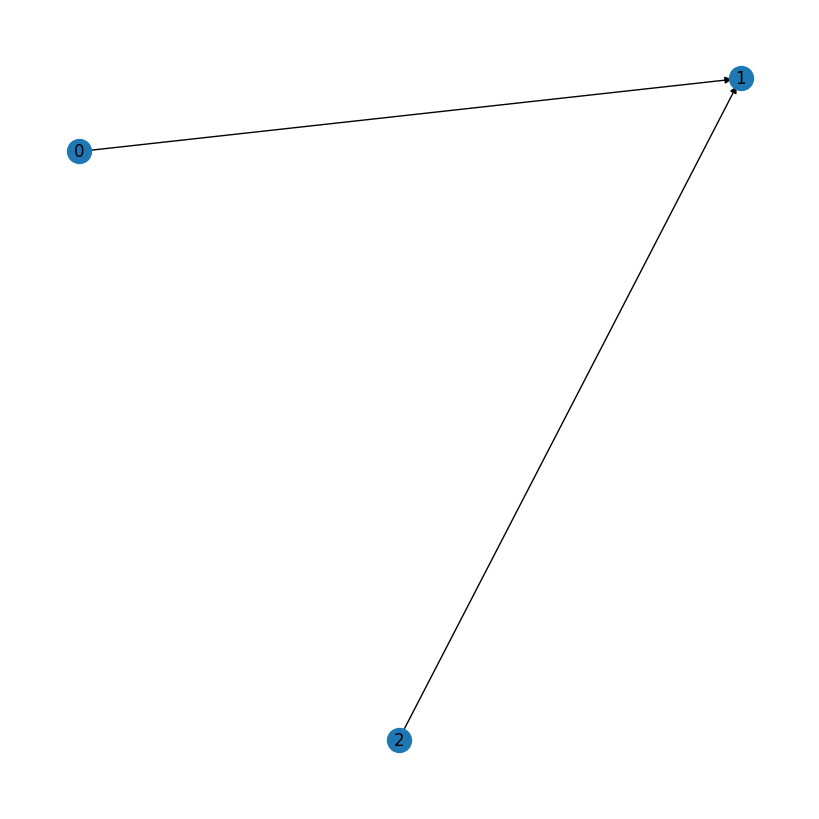

In [235]:
draw_graph(data)
# https://stackoverflow.com/questions/28533111/plotting-networkx-graph-with-node-labels-defaulting-to-node-name

In [222]:
type(dataset[0])

torch_geometric.data.data.Data

In [223]:
dataset = dataset.shuffle()

train_dataset = dataset[:150]
test_dataset = dataset[150:]

print(f'Num train graphs: {len(train_dataset)}')
print(f'Num test graphs: {len(test_dataset)}')

Num train graphs: 150
Num test graphs: 38


In [224]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step+1}')
    print(f'Num graphs in batch: {data.num_graphs}')
    print(data)
    print()

Step 1
Num graphs in batch: 64
DataBatch(edge_index=[2, 2682], x=[1207, 7], edge_attr=[2682, 4], y=[64], batch=[1207], ptr=[65])

Step 2
Num graphs in batch: 64
DataBatch(edge_index=[2, 2436], x=[1110, 7], edge_attr=[2436, 4], y=[64], batch=[1110], ptr=[65])

Step 3
Num graphs in batch: 22
DataBatch(edge_index=[2, 874], x=[396, 7], edge_attr=[874, 4], y=[22], batch=[396], ptr=[23])



In [225]:
from torch.nn import Linear
import torch.nn.functional as F

from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)

        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()

        x = self.conv2(x, edge_index)
        x = x.relu()

        x = self.conv3(x, edge_index)

        # 2. readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

model = GCN(hidden_channels=64)
print(model)


GCN(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [226]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:
        out = model(data.x, data.edge_index, data.batch)    # single forward pass over the batch
        loss = criterion(out, data.y)
        loss.backward()         # derive gradients
        optimizer.step()        # update weights
        optimizer.zero_grad()   # clear gradients

In [227]:
def eval(loader):
    model.eval()
    correct = 0
    total_loss = 0
    for data in loader:
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        total_loss += loss.item()
        pred = out.argmax(dim=1)

        correct += int((pred == data.y).sum())
    return correct/len(loader.dataset), total_loss/len(loader.dataset)

In [228]:
from tqdm.auto import trange

for epoch in trange(1, 50):
    train()
    train_acc, train_loss = eval(train_loader)
    test_acc, test_loss = eval(test_loader)

    if epoch == 1 or epoch == 49:
        print(f'Train loss = {train_loss:.4f}, train accuracy = {train_acc*100:,.2f}%')
        print(f'Test loss = {test_loss:.4f}, test accuracy = {test_acc*100:,.2f}%')

    torch.save(model, 'graph_classification_model.pt')

  0%|          | 0/49 [00:00<?, ?it/s]

  4%|▍         | 2/49 [00:00<00:10,  4.61it/s]

Train loss = 0.0135, train accuracy = 66.00%
Test loss = 0.6736, test accuracy = 68.42%


100%|██████████| 49/49 [00:11<00:00,  4.16it/s]

Train loss = 0.0103, train accuracy = 72.67%
Test loss = 0.5003, test accuracy = 71.05%
